In [1]:
import requests
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# Bounding box of the requested data
lon_min = 12.490704059600828
lat_min = 41.884179760604795
lon_max = 12.508814334869385
lat_max = 41.89488221408869

In [3]:
overpass_url = "http://overpass-api.de/api/interpreter"

In [4]:
# Overpass-turbo query for amenity=restaurant
query = "[out:json][timeout:25];"
query += f"node[\"amenity\"=\"restaurant\"]{lat_min, lon_min, lat_max, lon_max};"
query += "out;"

In [5]:
# Request data from overpass-turbo
overpass_request = requests.get(overpass_url, params={"data": query})

# Get the json object from the request
features = overpass_request.json()

In [6]:
# GeoDataFrame columns
columns = ["osmid", "cuisine", "name", "opening_hours", "phone", "email", "website", "geometry"]

# Create an empty GeoDataFrame
restaurants = gpd.GeoDataFrame(columns=columns)

In [7]:
# Get the features from the json
for feature in features["elements"]:
    tags =  feature["tags"]
    data = [feature["id"] if column == "osmid" 
            else Point(feature["lon"], feature["lat"]) if column=="geometry" 
            else tags.get(column, None) for column in columns]
    
    # Append each feature to the GeoDataFrame
    restaurants.loc[-1] = data
    restaurants.index = restaurants.index + 1
    restaurants = restaurants.sort_index()

# Set CRS 3857 for plotting
restaurants = restaurants.set_crs(epsg=4326).to_crs(epsg=3857)

In [8]:
restaurants.head()

,osmid,cuisine,name,opening_hours,phone,email,website,geometry
0,8917220218,None,Shamrock,None,None,None,None,POINT (1391187.150 5144365.162)
1,8387143275,fish,Baia Chia,None,+39 339 1135460,None,https://www.ristorantebaiachia.it/,POINT (1391765.466 5144771.665)
2,8387143259,None,Da Nino,None,+39 06 70453458,None,None,POINT (1391711.420 5144855.827)
3,8387137795,fish,Pescetto,None,+39 06 45504839,None,None,POINT (1391632.684 5144889.041)
4,8303005269,chinese,Tea & Noodles,None,+390664017124,None,None,POINT (1392245.409 5145024.512)


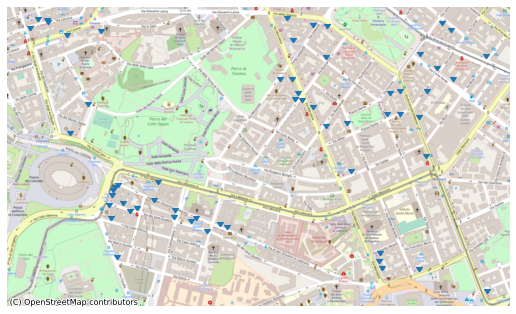

In [9]:
# Plot the result
ax = restaurants.plot(figsize=(9,9), marker=7)

# Add OSM basemap
cx.add_basemap(ax,
               crs=restaurants.crs.to_string(),
               source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()